In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_sub_matrices(A, Q, indices):
    sub_matrices = []
    M = A.shape[0]  # Assuming A is a numpy array and square

    for idx in indices:
        i, j = idx
        if i*Q < M and j*Q < M:  # Check if indices are valid
            sub_matrix = A[i*Q:(i+1)*Q, j*Q:(j+1)*Q]
            sub_matrices.append(sub_matrix)
        else:
            sub_matrices.append(None)  # Or handle invalid index differently

    return sub_matrices

def insert_dividers(matrix, context_points, divider_width=1):
    total_rows, total_cols = matrix.shape

    # Insert row dividers
    insert_positions = np.arange(context_points, total_rows, context_points)
    insert_positions = np.repeat(insert_positions,
                                    divider_width)  # repeat the insert positions for each row divider
    matrix = np.insert(matrix, insert_positions, np.nan, axis=0)

    # Update total_rows and total_cols after row dividers insertion
    total_rows, total_cols = matrix.shape

    # Insert column dividers
    insert_positions = np.arange(context_points, total_cols, context_points)
    insert_positions = np.repeat(insert_positions,
                                    divider_width)  # repeat the insert positions for each column divider
    matrix = np.insert(matrix, insert_positions, np.nan, axis=1)

    return matrix

def calculate_tick_positions(matrix_size, context_points, divider_width):
    positions = np.arange(0, matrix_size, context_points + divider_width)
    adjusted_positions = positions + (context_points + divider_width) // 2 - divider_width
    return adjusted_positions  # Exclude the last position which is beyond the matrix


def reorder_attention_matrix(attention, current_order, target_order, context_points):
    """Reorder the attention matrix based on the target electrode order, considering sub-squares."""
    num_electrodes = len(current_order)
    reordered_attention = np.zeros_like(attention)

    # Create a mapping from electrode names to their indices
    current_indices = {electrode: i for i, electrode in enumerate(current_order)}
    target_indices = [current_indices[electrode] for electrode in target_order]

    # Reorder sub-squares in the attention matrix
    for i, target_idx in enumerate(target_indices):
        for j, target_jdx in enumerate(target_indices):
            source_i, source_j = int(target_idx * context_points), int(target_jdx * context_points)
            dest_i, dest_j = int(i * context_points), int(j * context_points)
            reordered_attention[dest_i:dest_i + context_points, dest_j:dest_j + context_points] =  attention[source_i:source_i + context_points, source_j:source_j + context_points]

    return reordered_attention


def combined_plot(attention_matrices, electrode_names, plot_titles, context_points, maxval=0.05, same_order=False, put_text=False, plot_size=(20, 10)):
    if same_order and len(attention_matrices) > 1 and len(electrode_names) > 1:
        attention_matrices[1] = reorder_attention_matrix(attention_matrices[1], electrode_names[1], electrode_names[0], context_points)
        electrode_names[1] = electrode_names[0]
        
    nrows = 1
    ncols = len(attention_matrices)
    fig, ax = plt.subplots(figsize=plot_size, dpi=100, nrows=nrows, ncols=ncols)
    
    # make sure ax is iterable
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])

    for i, attention in enumerate(attention_matrices):
        attention_with_dividers = insert_dividers(attention, context_points)
        tick_positions = calculate_tick_positions(attention_with_dividers.shape[0], context_points, 1)

        ax[i].set_xticks(tick_positions)
        ax[i].set_yticks(tick_positions)
        ax[i].set_xticklabels(electrode_names[i], rotation=90)
        ax[i].set_yticklabels(electrode_names[i])
        ax[i].xaxis.tick_top()

        ax[i].imshow(attention_with_dividers, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=maxval)

        ax[i].set_title(plot_titles[i])

        if put_text:
            # put text of values into each cell
            for x in range(attention_with_dividers.shape[0]):
                for y in range(attention_with_dividers.shape[1]):
                    if not np.isnan(attention_with_dividers[x, y]):
                        ax[i].text(y, x, '{:.2f}'.format(attention_with_dividers[x, y]),
                                horizontalalignment='center',
                                verticalalignment='center',
                                color='white', fontsize=6)

    # Adjust layout for colorbar
    plt.subplots_adjust(bottom=0.15)
    cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.05])  # Adjust as needed
    fig.colorbar(ax[0].images[0], cax=cbar_ax, orientation='horizontal')
    ax[0].set_ylabel('Electrode')

    return fig, ax
    # return attention_matrices[0], attention_matrices[1]


def blow_up(matrix, N):
    # Repeat each element in each row N times
    repeated_rows = np.repeat(matrix, N, axis=1)
    # Repeat each row N times
    blown_up_matrix = np.repeat(repeated_rows, N, axis=0)
    return blown_up_matrix


# test made by hand to make sure reordering matrix is working correct

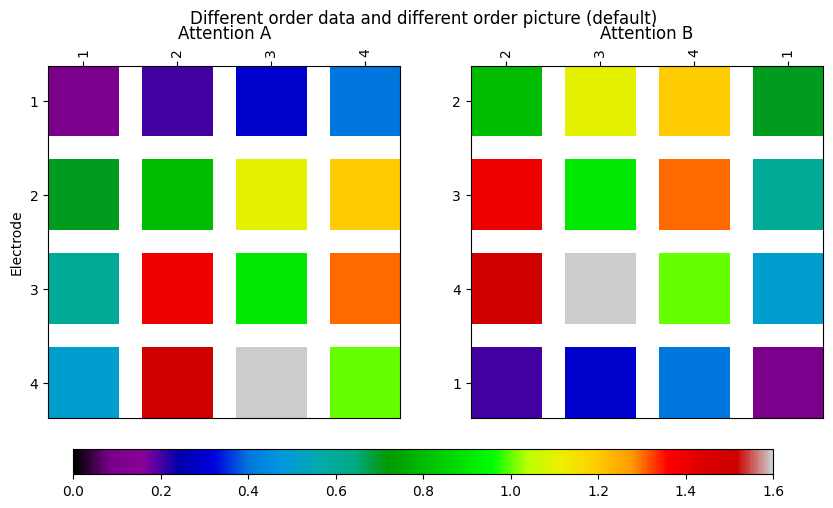

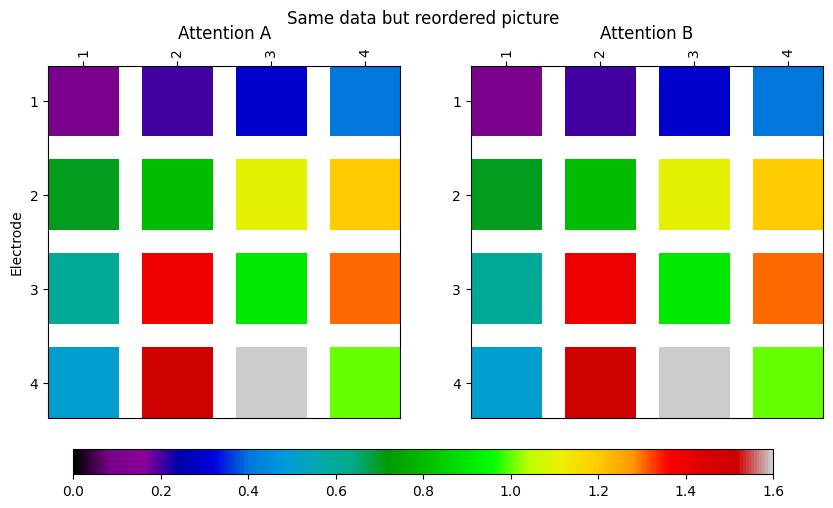

In [3]:
repsize = 3 
attention1 = blow_up(np.array([[0.1, 0.2, 0.3, 0.4],
                       [0.7, 0.8, 1.1, 1.2,],
                       [0.6, 1.4, 0.9, 1.3,],
                       [0.5, 1.5, 1.6, 1.0,],]),repsize)

attention2 = blow_up(np.array([[0.8, 1.1, 1.2, 0.7],
                               [1.4, 0.9, 1.3, 0.6,],
                               [1.5, 1.6, 1.0, 0.5,],
                               [0.2, 0.3, 0.4, 0.1,],]),repsize)

titles = ["Attention A",
          "Attention B"]
names = ["1,2,3,4".split(','), 
         "2,3,4,1".split(',')]
fig,ax = combined_plot([attention1, attention2], names, titles, repsize, same_order=False, maxval=1.6,plot_size=(10,5));
plt.suptitle('Different order data and different order picture (default)')
fig,ax = combined_plot([attention1, attention2], names, titles, repsize, same_order=True, maxval=1.6,plot_size=(10,5));
plt.suptitle('Same data but reordered picture');

# All plots from here after will be same order and specified if different data
---

# Test EDF_TEST_1 vs EDF_TEST_1_1
Info for both runs.

- Same params and data on two runs; 1 run after the other
    - making sure it converges to a similar idea after 10 epochs
- ONLY difference is second run was --run_name EDF_TEST_1_1

```bash
python train.py spacetimeformer EDF --data_path /home/wendeldr/git/spacetimeformer/spacetimeformer/data/edf/OvertNaming.EDF --run_name EDF_TEST_1 --context_points 32 --target_points 1 --n_heads 1 --enc_layers 1 --dec_layers 1 --d_model 100 --d_qk 100 --d_v 100 --d_ff 400 --global_self_attn full --local_self_attn full --global_cross_attn full --local_cross_attn full --batch_size 2000 --attn_plot --plot --plot_samples 1 --max_epochs 10 --gpus 2 --channels "SP1,SP2,TO1,TO2,TO'1,TO'2"
```

Notes

### **Predictions were not done on exact same data, the part of the code that pulls these is apperently using random indexs. Working on updating it**


- similar but not exact same apperence (not same data).
    - over all the electrode to electrode relationships seem to be holding


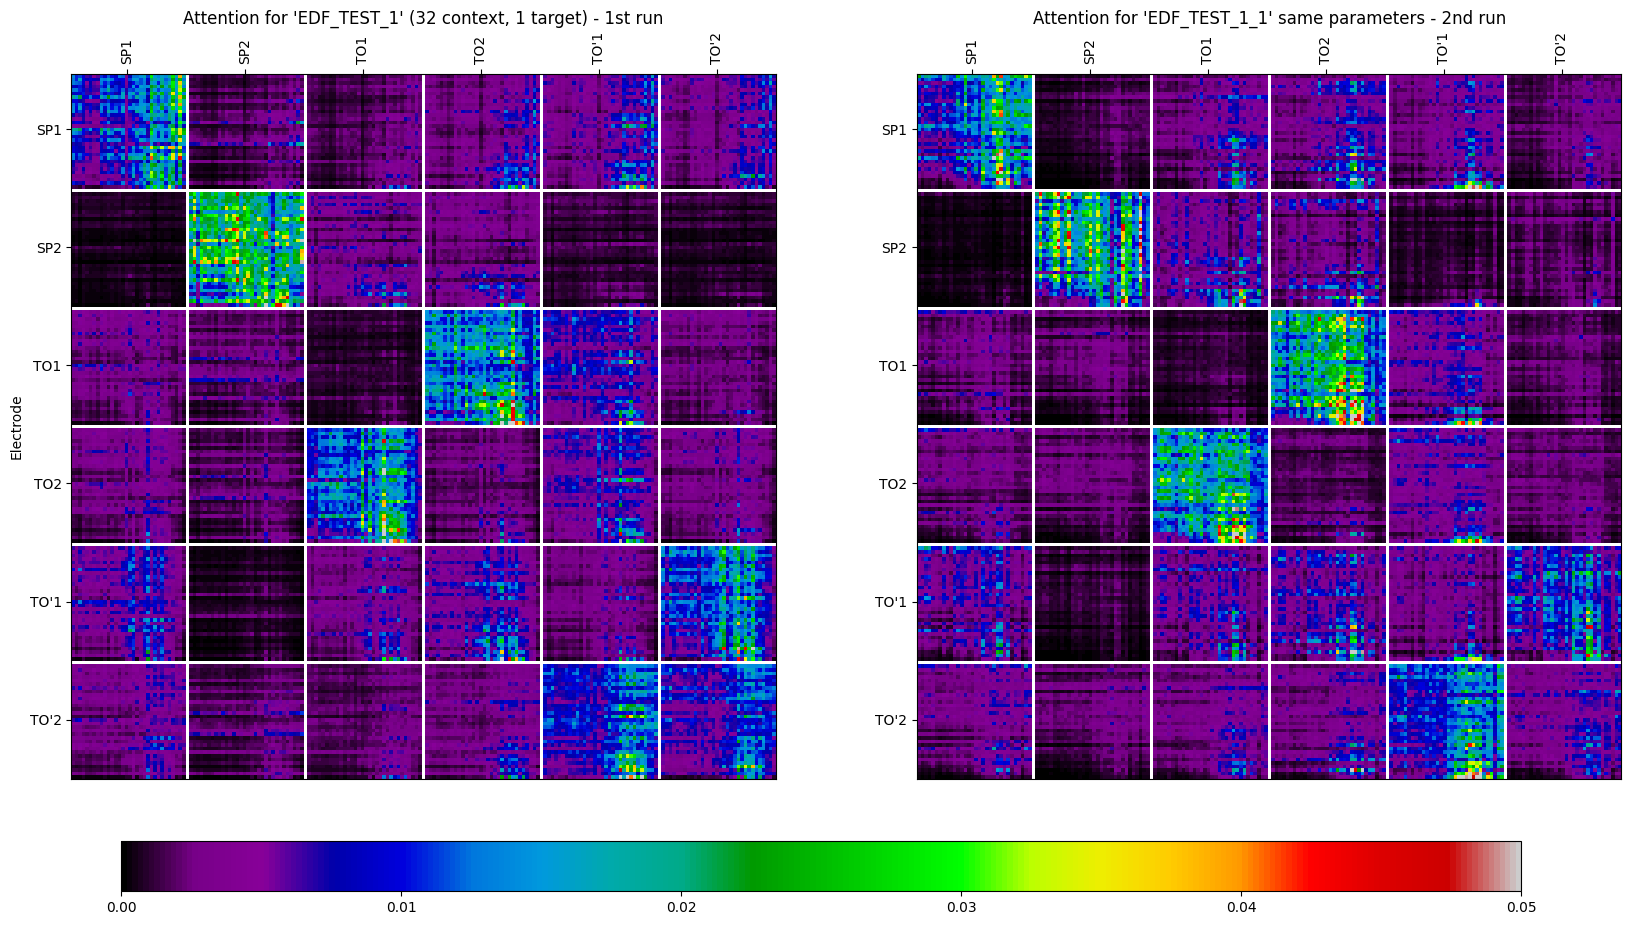

In [4]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_103434-79tgbfm9/files/self_attn_1000_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_105844-sn1v3ot4/files/self_attn_1000_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

titles = ["Attention for 'EDF_TEST_1' (32 context, 1 target) - 1st run",
          "Attention for 'EDF_TEST_1_1' same parameters - 2nd run"]
names = ["SP1,SP2,TO1,TO2,TO'1,TO'2".split(','), 
         "SP1,SP2,TO1,TO2,TO'1,TO'2".split(',')]
combined_plot([attention1, attention2], names, titles, 32, same_order=True);

# Test EDF_TEST_2 vs EDF_TEST_2_1
- same input and idea as previous EDF_TEST_1 vs EDF_TEST_1_1
- first electrode rotated to end of list
```--channels "SP2,TO1,TO2,TO'1,TO'2,SP1"```
- comparison of two runs with rotated run one after other


Notes:
- Similar to previous test. In general trends are similar. Differences most likely due to differences in data being predicted 

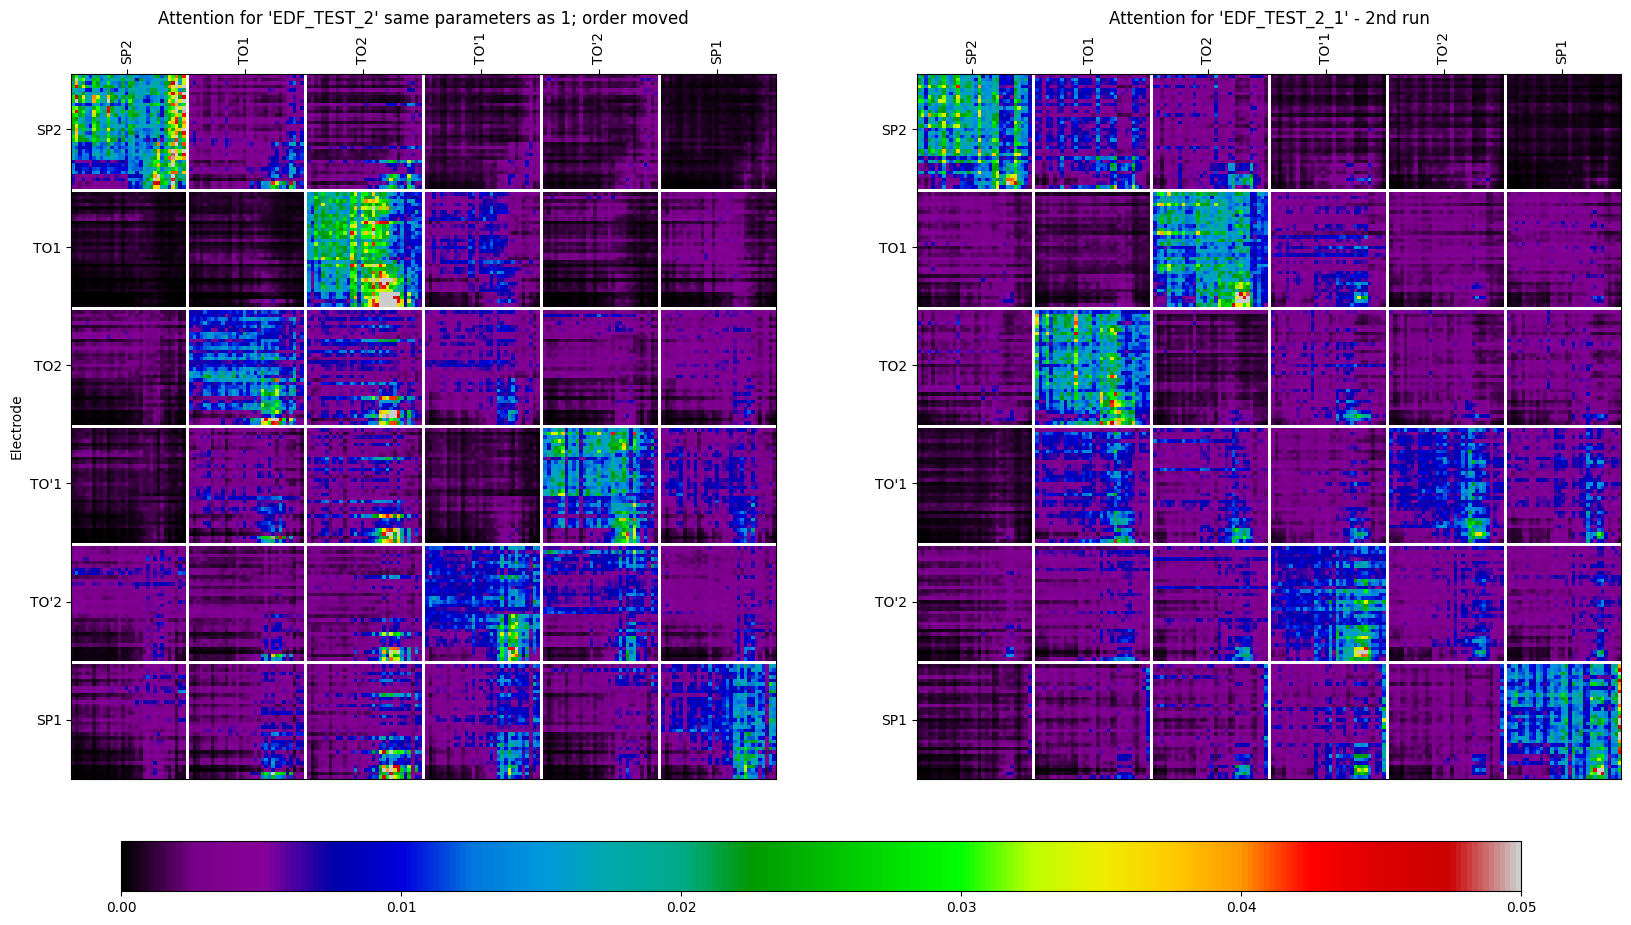

In [5]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_112247-905stowf/files/self_attn_1000_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_114702-wangty5s/files/self_attn_1000_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

titles = ["Attention for 'EDF_TEST_2' same parameters as 1; order moved",
          "Attention for 'EDF_TEST_2_1' - 2nd run"]
names = ["SP2,TO1,TO2,TO'1,TO'2,SP1".split(','), 
         "SP2,TO1,TO2,TO'1,TO'2,SP1".split(',')]
combined_plot([attention1, attention2], names, titles, 32, same_order=True);

# Compare EDF_TEST_1 vs EDF_TEST_2 
(SP1,SP2,TO1,TO2,TO'1,TO'2  vs  SP2,TO1,TO2,TO'1,TO'2,SP1)
- Does perturbation electrodes make a difference? 
    - Order **IS** different in underlying attention matrix's, data is reordered for easier comparison in images

Notes 
- similar patterning in general. Minor changes likely due to different data; will repeat once code is repeatable 

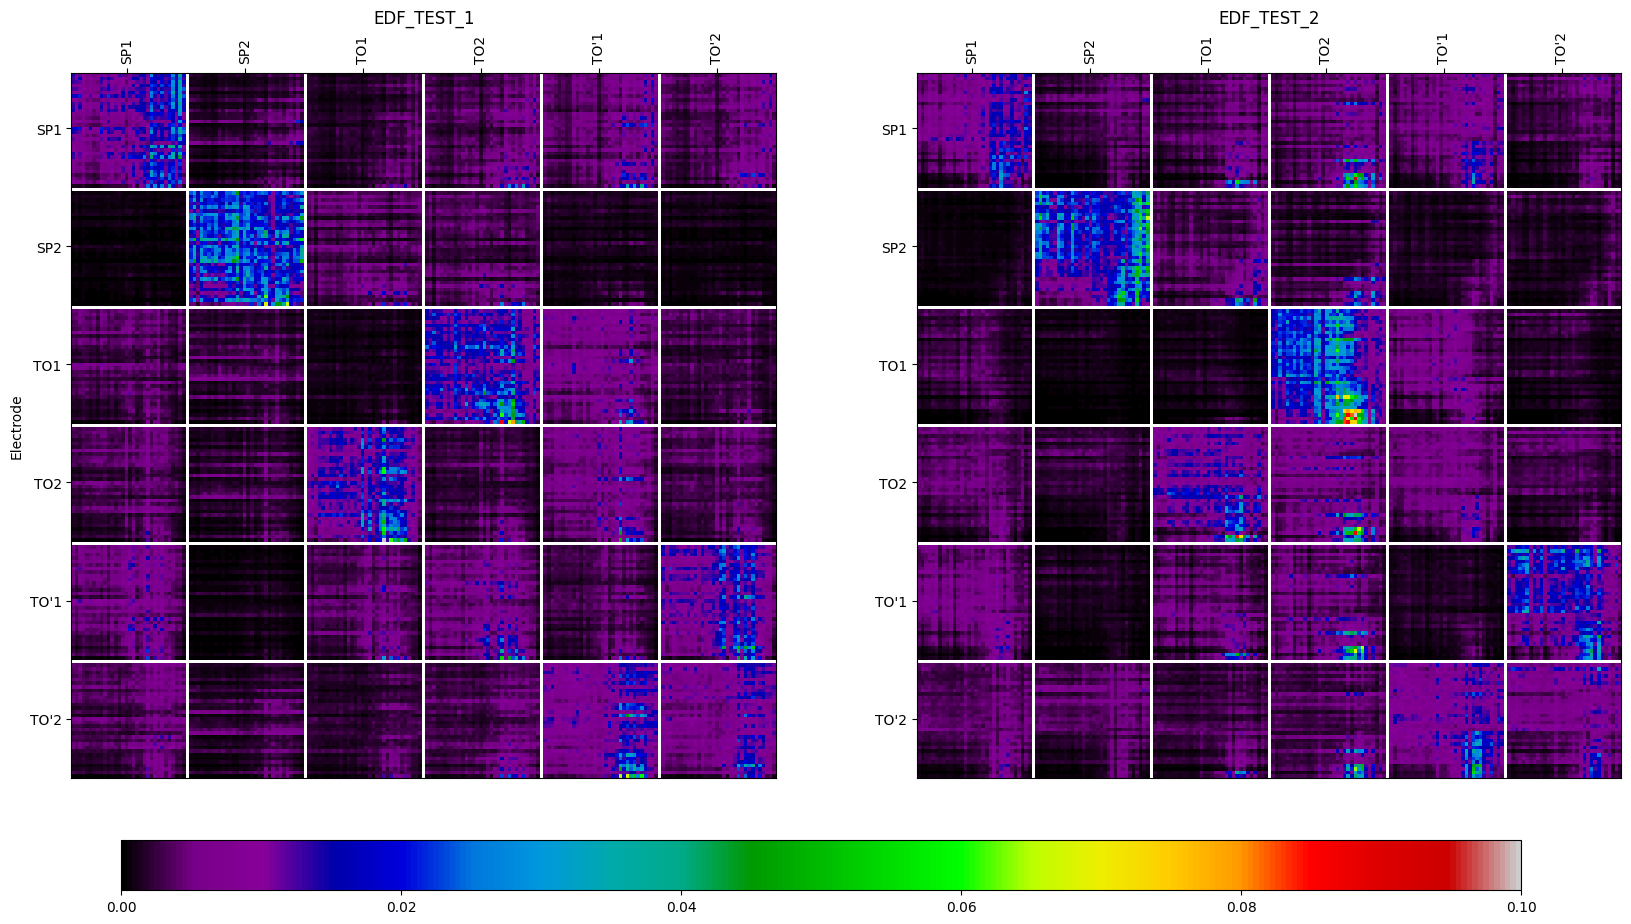

In [6]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_103434-79tgbfm9/files/self_attn_1000_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_112247-905stowf/files/self_attn_1000_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

titles = ["EDF_TEST_1",
          "EDF_TEST_2"]
names = ["SP1,SP2,TO1,TO2,TO'1,TO'2".split(','), 
         "SP2,TO1,TO2,TO'1,TO'2,SP1".split(',')]
combined_plot([attention1, attention2], names, titles, 32, same_order=True, maxval=.1);

# Rotation in middle (EDF_TEST_1 vs EDF_TEST_3)
- same idea as moving first electrode to end of list, just moving two different electrodes in middle of array

SP1,**SP2**,**TO1**,TO2,TO'1,TO'2 vs SP1,**TO1**,**SP2**,TO2,TO'1,TO'2

Notes
- same ideas as other tests

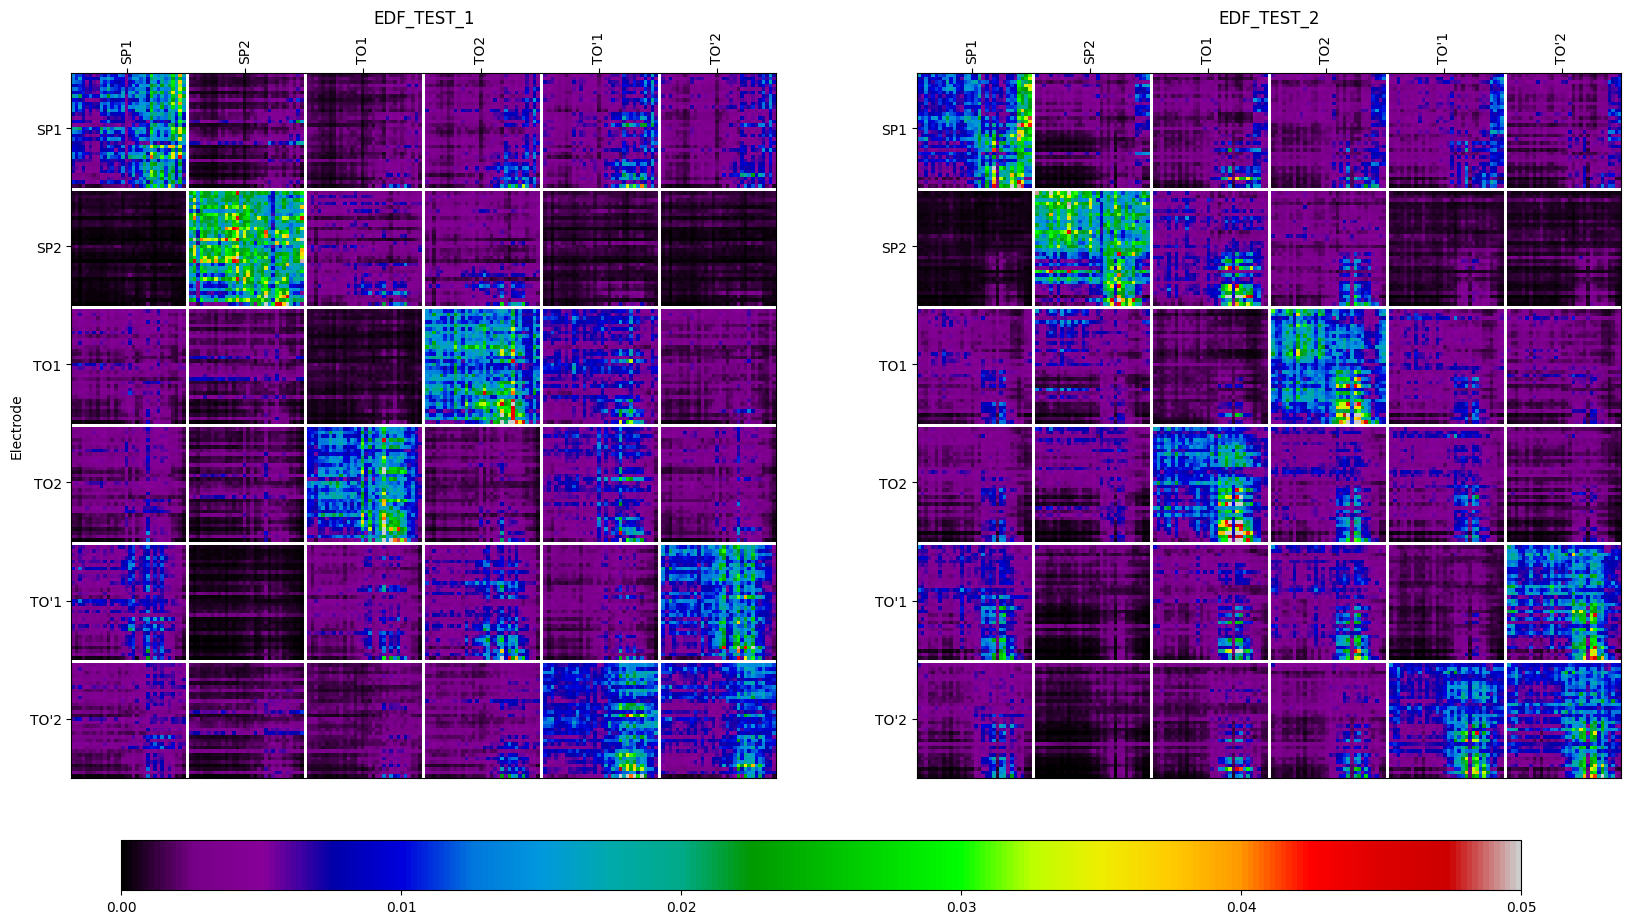

In [7]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_103434-79tgbfm9/files/self_attn_1000_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_121108-f5jr2qzb/files/self_attn_1000_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

titles = ["EDF_TEST_1",
          "EDF_TEST_2"]
names = ["SP1,SP2,TO1,TO2,TO'1,TO'2".split(','), 
         "SP1,TO1,SP2,TO2,TO'1,TO'2".split(',')]
combined_plot([attention1, attention2], names, titles, 32, same_order=True);

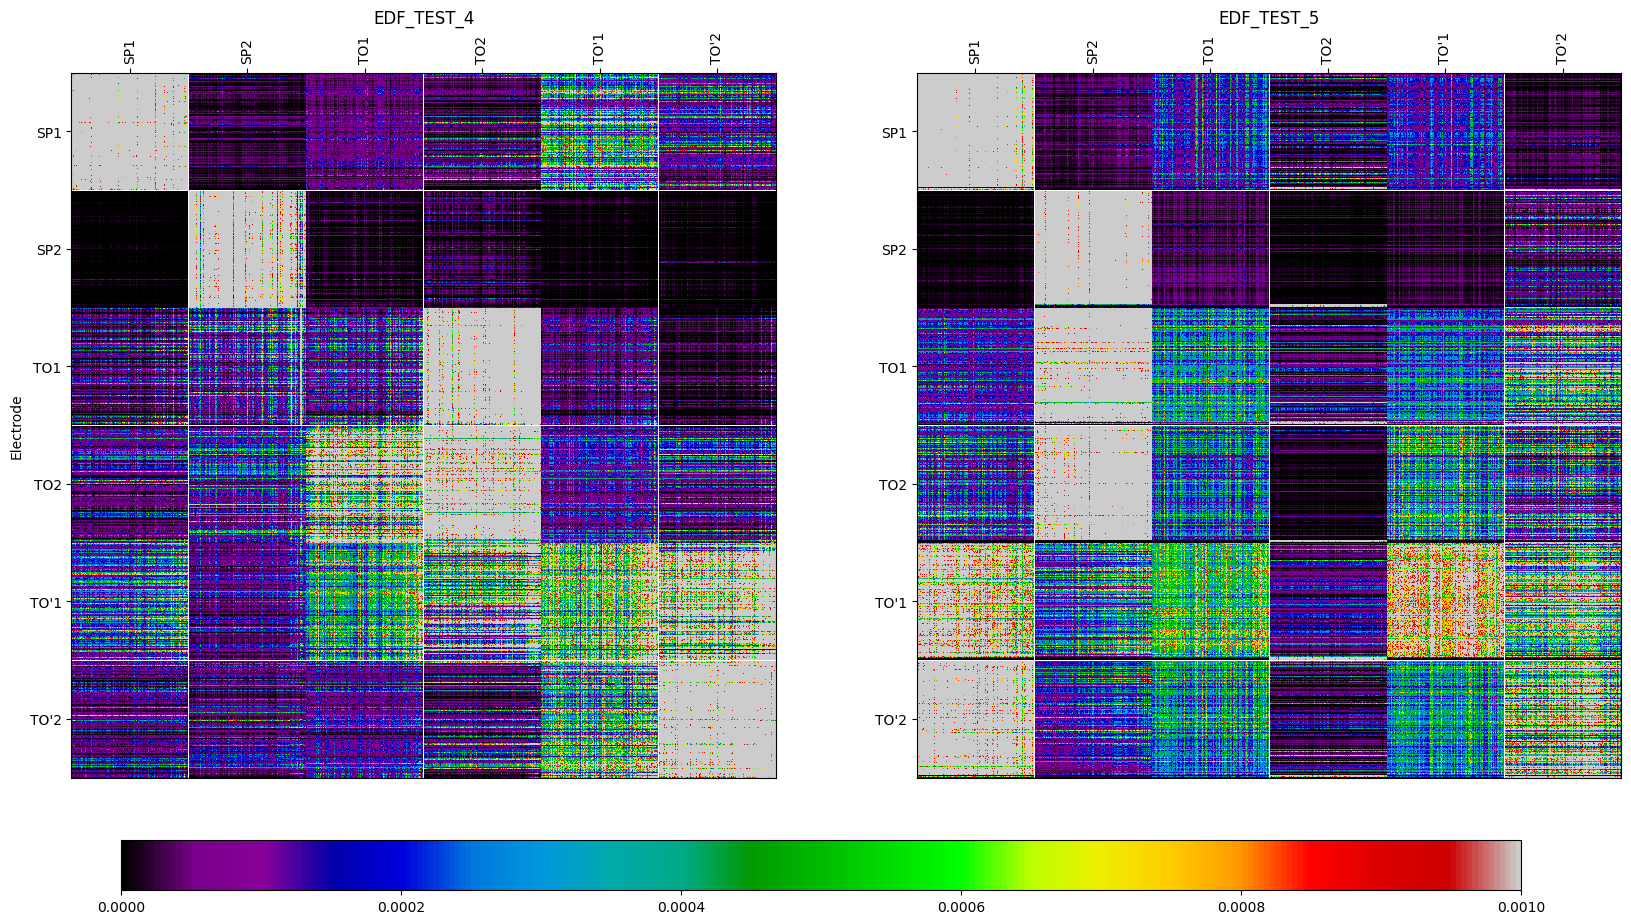

In [8]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_123431-rgayjs3o/files/self_attn_1990_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_130406-v7hab74y/files/self_attn_1990_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

titles = ["EDF_TEST_4",
          "EDF_TEST_5"]
names = ["SP1,SP2,TO1,TO2,TO'1,TO'2".split(','), 
         "SP2,TO1,TO2,TO'1,TO'2,SP1".split(',')]
combined_plot([attention1, attention2], names, titles, 256, maxval=0.001, same_order=True);

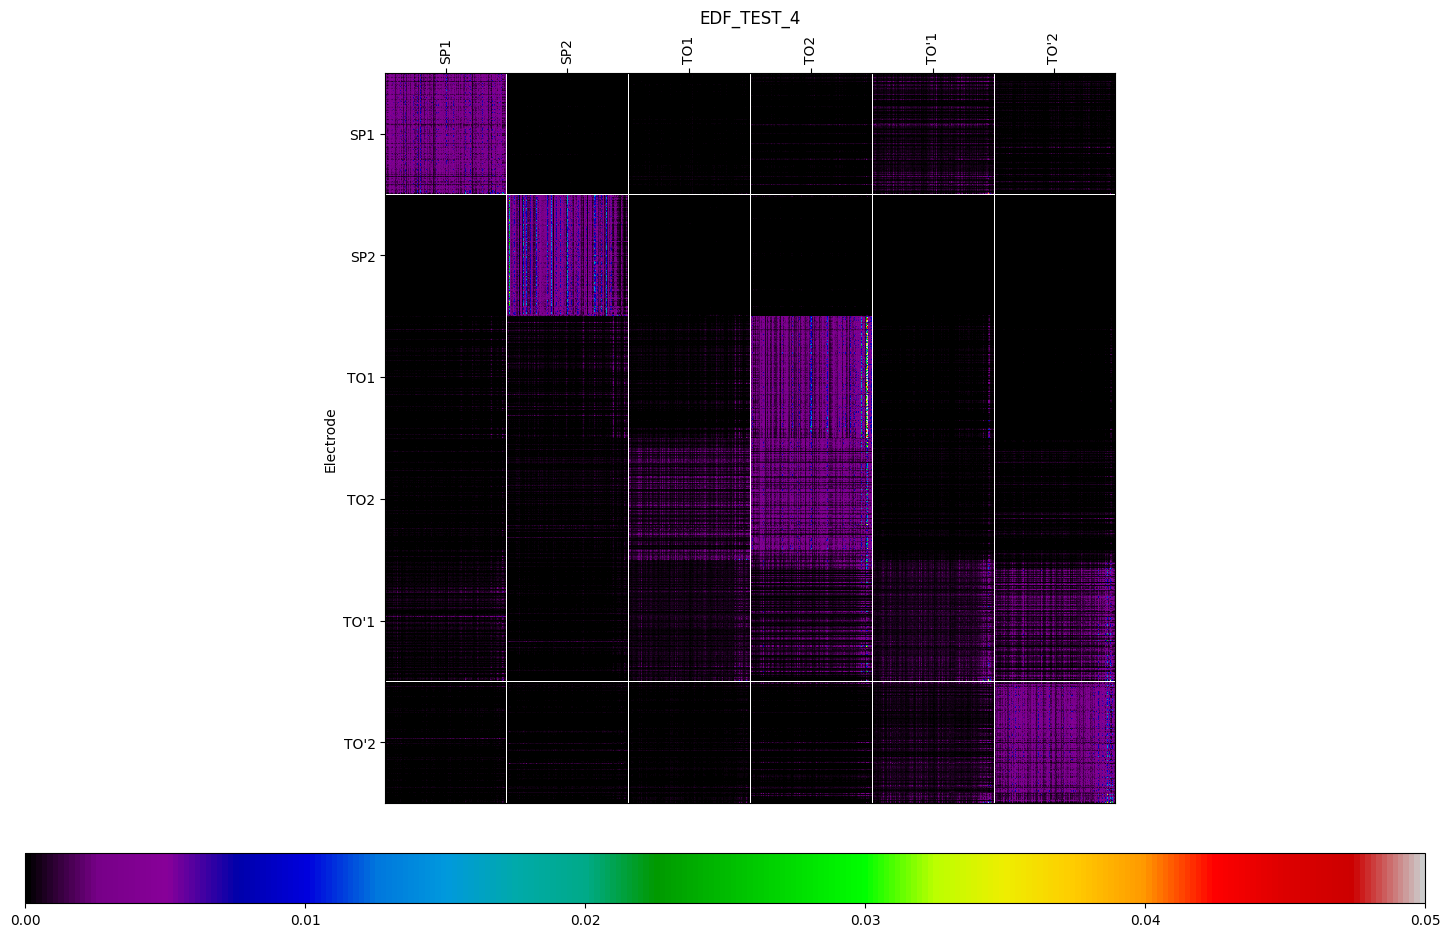

In [9]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_123431-rgayjs3o/files/self_attn_1990_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/set1_differing_data/offline-run-20240126_130406-v7hab74y/files/self_attn_1990_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

titles = ["EDF_TEST_4"]
names = ["SP1,SP2,TO1,TO2,TO'1,TO'2".split(',')]
combined_plot([attention1], names, titles, 256, maxval=0.05, same_order=True);

Text(0, 0.5, 'TO2')

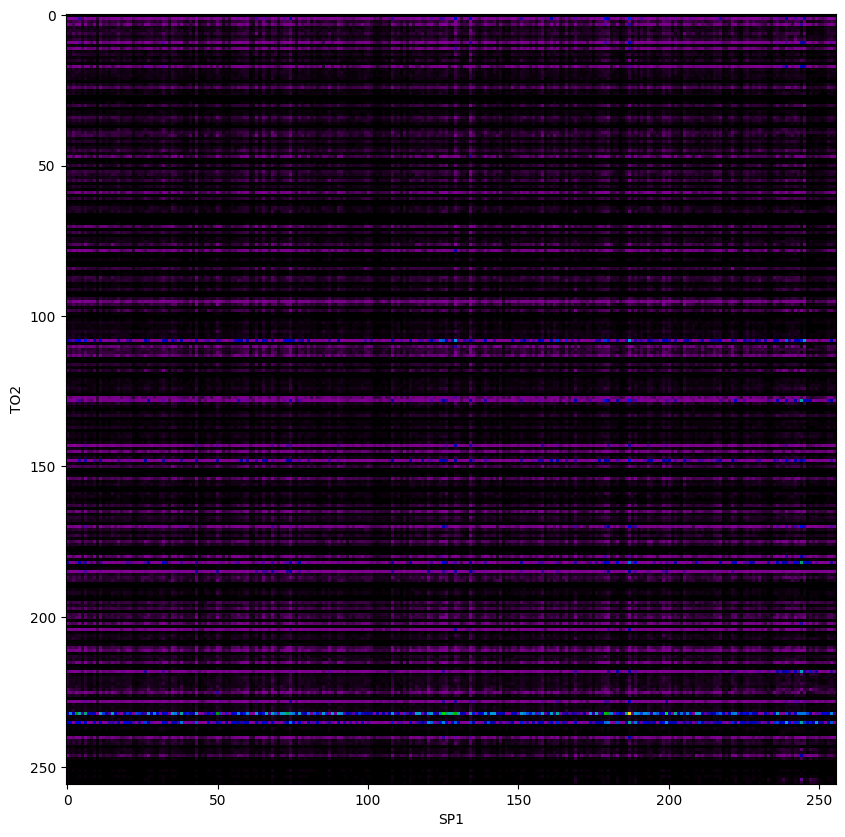

In [10]:
X = 0
Y = 3
a = get_sub_matrices(attention1, 256, [(X,Y)])[0]
plt.figure(figsize=(10,10))
plt.imshow(a, cmap='nipy_spectral', interpolation='none', vmin=0, vmax=0.006)
plt.xlabel(names[0][X])
plt.ylabel(names[0][Y])

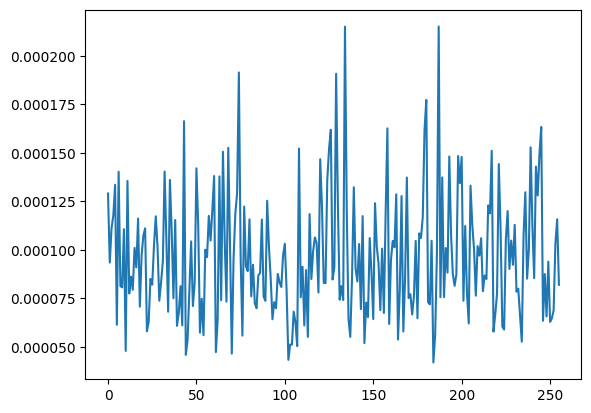

In [11]:
plt.plot(a[:,:].mean(axis=0).T);

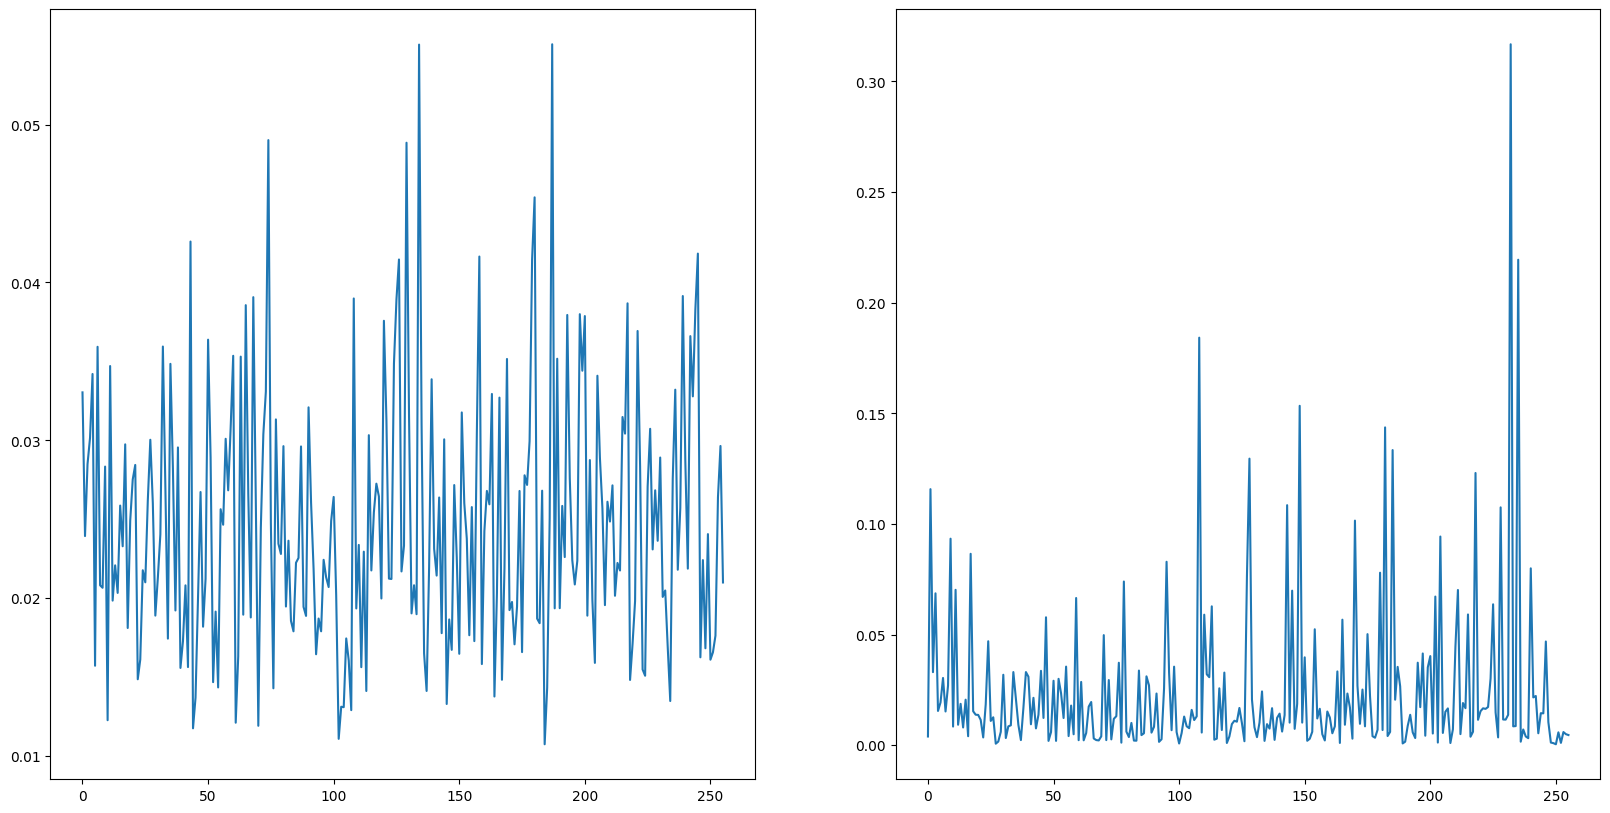

In [12]:
fig,ax = plt.subplots(1,2,figsize=(20,10),sharex=True)
ax[0].plot(a.sum(axis=0))
ax[1].plot(a.sum(axis=1))

set2

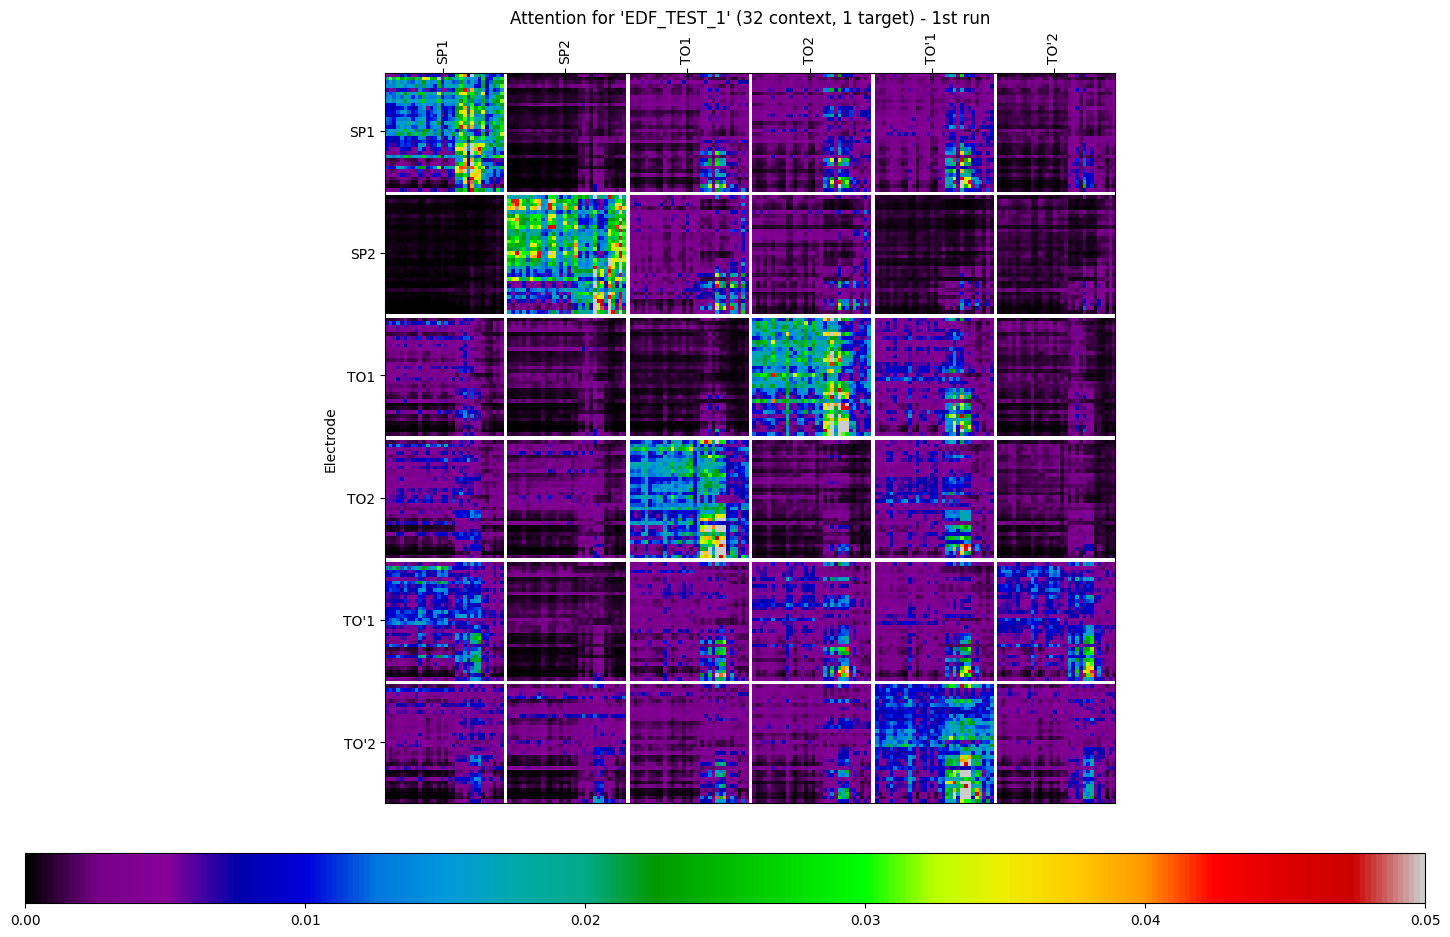

In [13]:
path1 = "/home/dan/Documents/images/singleTokenPreds/set1_same_data/offline-run-20240130_102952-9u8sxa0q/files/self_attn_1000_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]


titles = ["Attention for 'EDF_TEST_1' (32 context, 1 target) - 1st run"]
names = ["SP1,SP2,TO1,TO2,TO'1,TO'2".split(',')]
combined_plot([attention1], names, titles, 32, same_order=True, maxval=0.05);

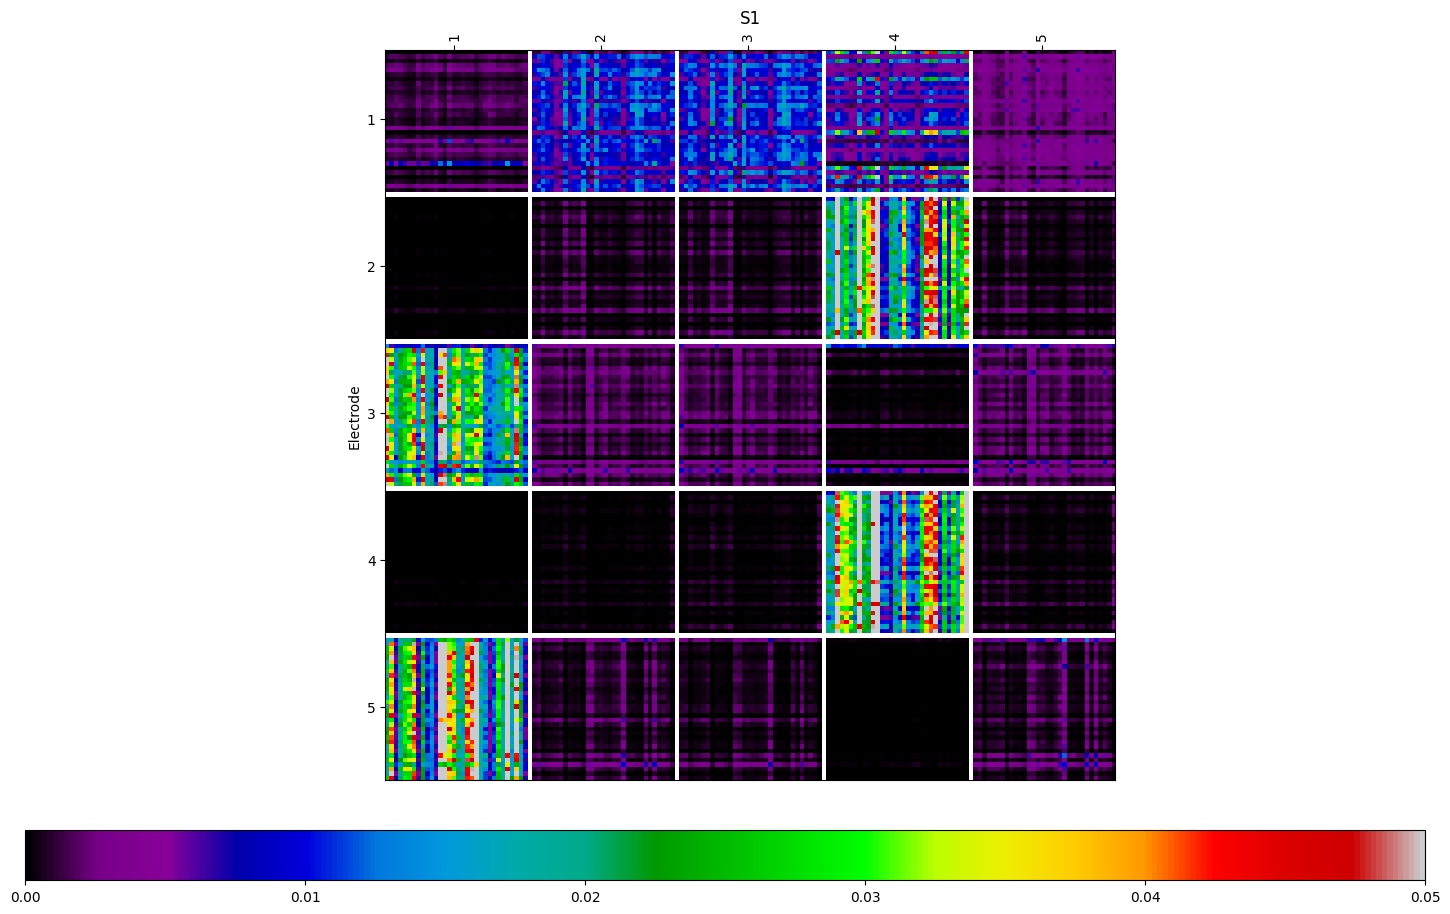

In [14]:
path1 = "/home/dan/Documents/images/singleTokenPreds/paper_nets/offline-run-20240130_135206-b3bn7hme/files/self_attn_930_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]
# attention1[:32,:]=0
titles = ["S1"]
names = ["1,2,3,4,5".split(',')]
combined_plot([attention1], names, titles, 32,maxval=.05);

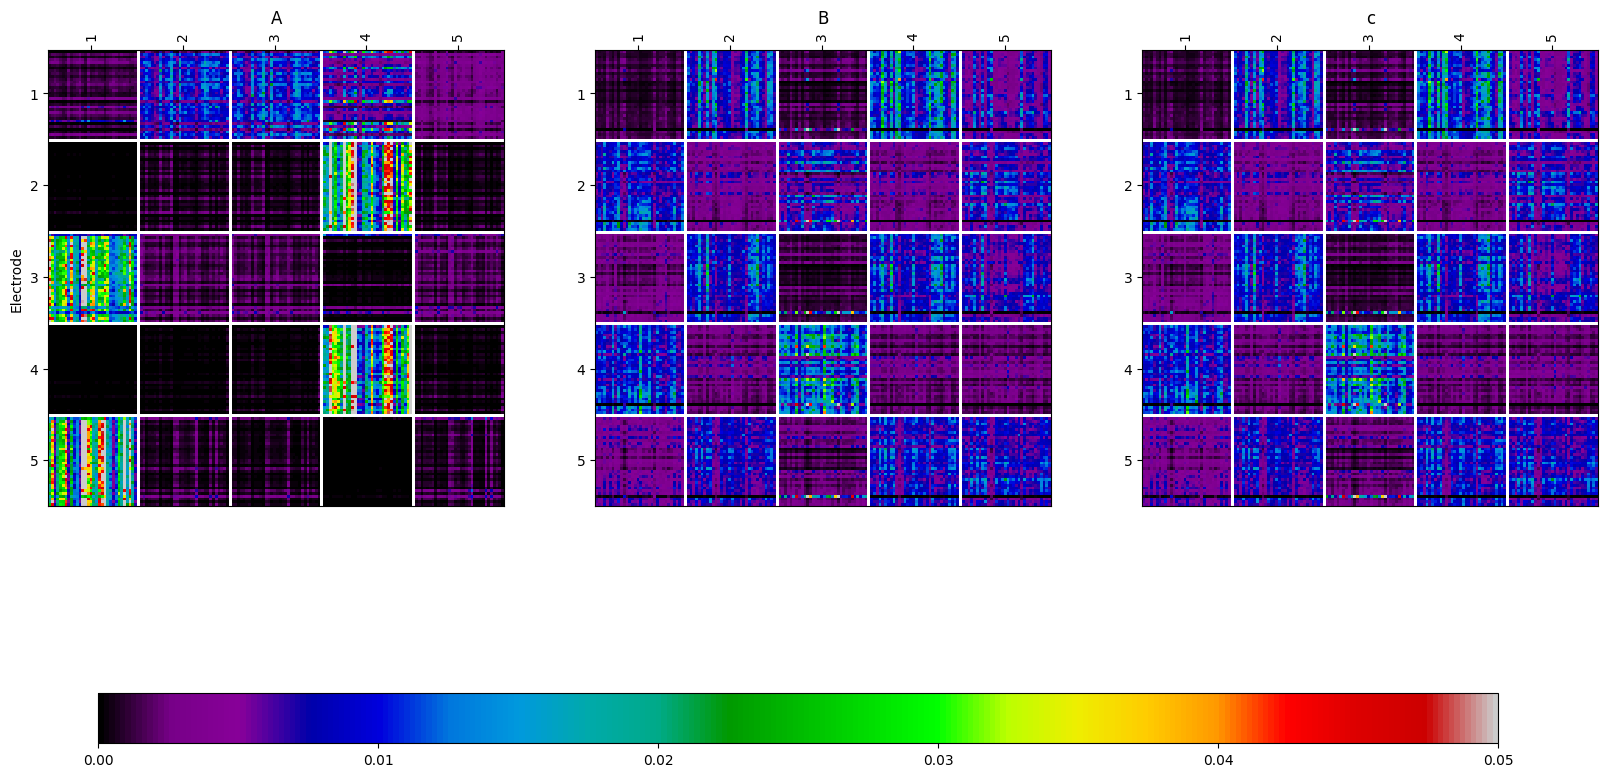

In [15]:
path1 = "/home/dan/Documents/images/singleTokenPreds/paper_nets/offline-run-20240130_135206-b3bn7hme/files/self_attn_930_layer_0.npy"
attention1 = np.load(path1)
attention1 = attention1[0, 0, :, :]

path2 = "/home/dan/Documents/images/singleTokenPreds/paper_nets/offline-run-20240130_142637-mye70z3j/files/self_attn_930_layer_0.npy"
attention2 = np.load(path2)
attention2 = attention2[0, 0, :, :]

path3 = "/home/dan/Documents/images/singleTokenPreds/paper_nets/offline-run-20240130_164138-hlo7yqc0/files/self_attn_930_layer_0.npy"
attention3 = np.load(path2)
attention3 = attention3[0, 0, :, :]
titles = ["A",
          "B","c"]
names = ["1,2,3,4,5".split(','), 
         "1,2,3,4,5".split(','),
         "1,2,3,4,5".split(',')]
combined_plot([attention1, attention2,attention3], names, titles, 32, same_order=True);

# S1

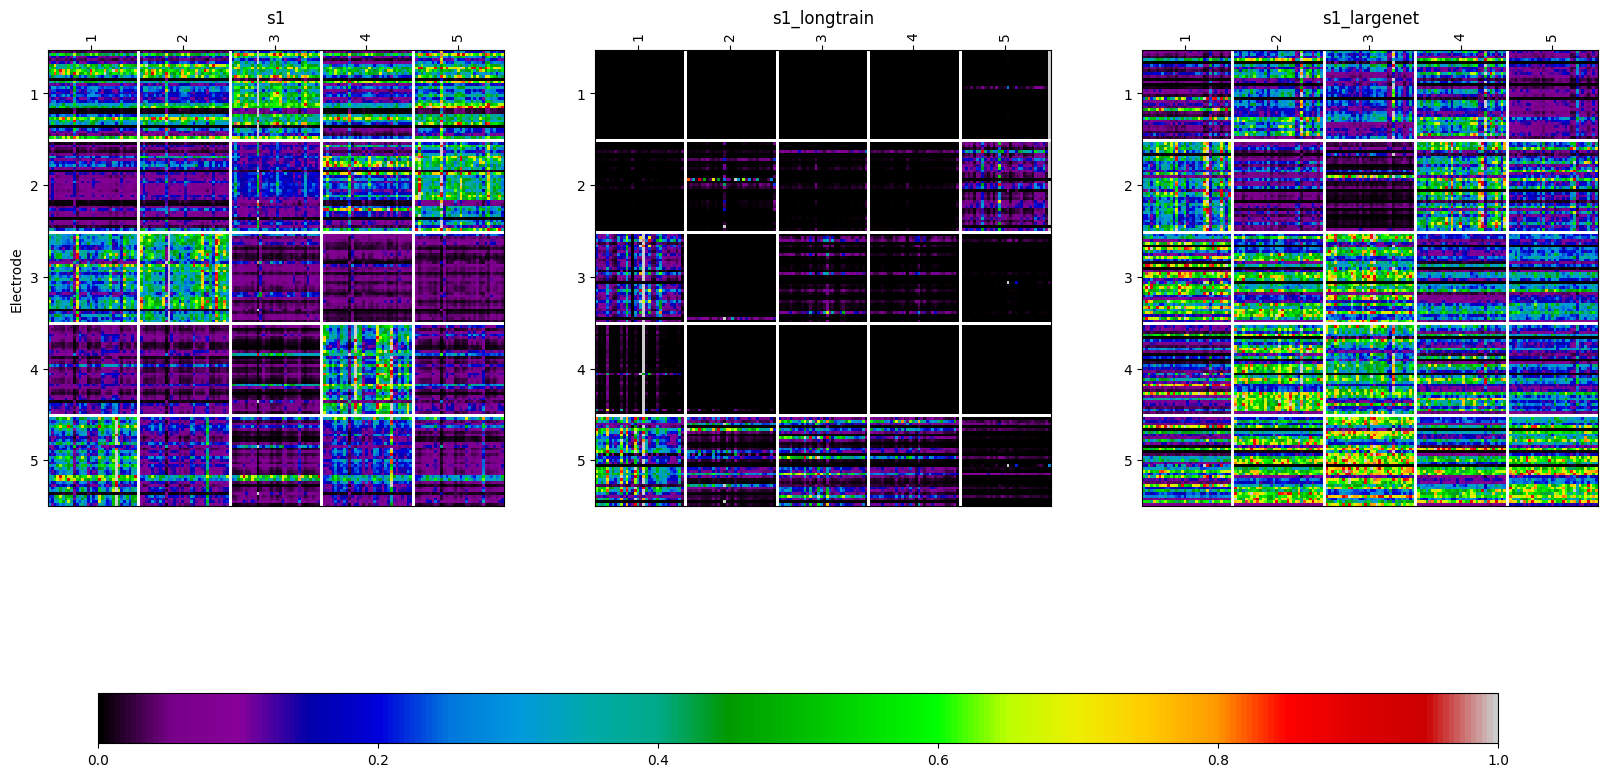

In [16]:
s1 = "/home/dan/Documents/images/singleTokenPreds/paper_nets/run-20240130_185331-79pp7ell/files/self_attn_930_layer_0_head_0.npy"
attention1 = np.load(s1)

s1_1_longerdatatandtrain = "/home/dan/Documents/images/singleTokenPreds/paper_nets/run-20240131_104110-rhnatgsr/files/self_attn_6150_layer_0_head_0.npy"
attention2 = np.load(s1_1_longerdatatandtrain)

s1_largenet = "/home/dan/Documents/images/singleTokenPreds/paper_nets/run-20240131_122125-8ucq37fq/files/self_attn_1968_layer_0_head_1.npy"
attention3 = np.load(s1_largenet)

titles = ["s1",
          "s1_longtrain","s1_largenet"]
names = ["1,2,3,4,5".split(','), 
         "1,2,3,4,5".split(','),
         "1,2,3,4,5".split(',')]
combined_plot([attention1, attention2,attention3], names, titles, 32, same_order=True, maxval=1);

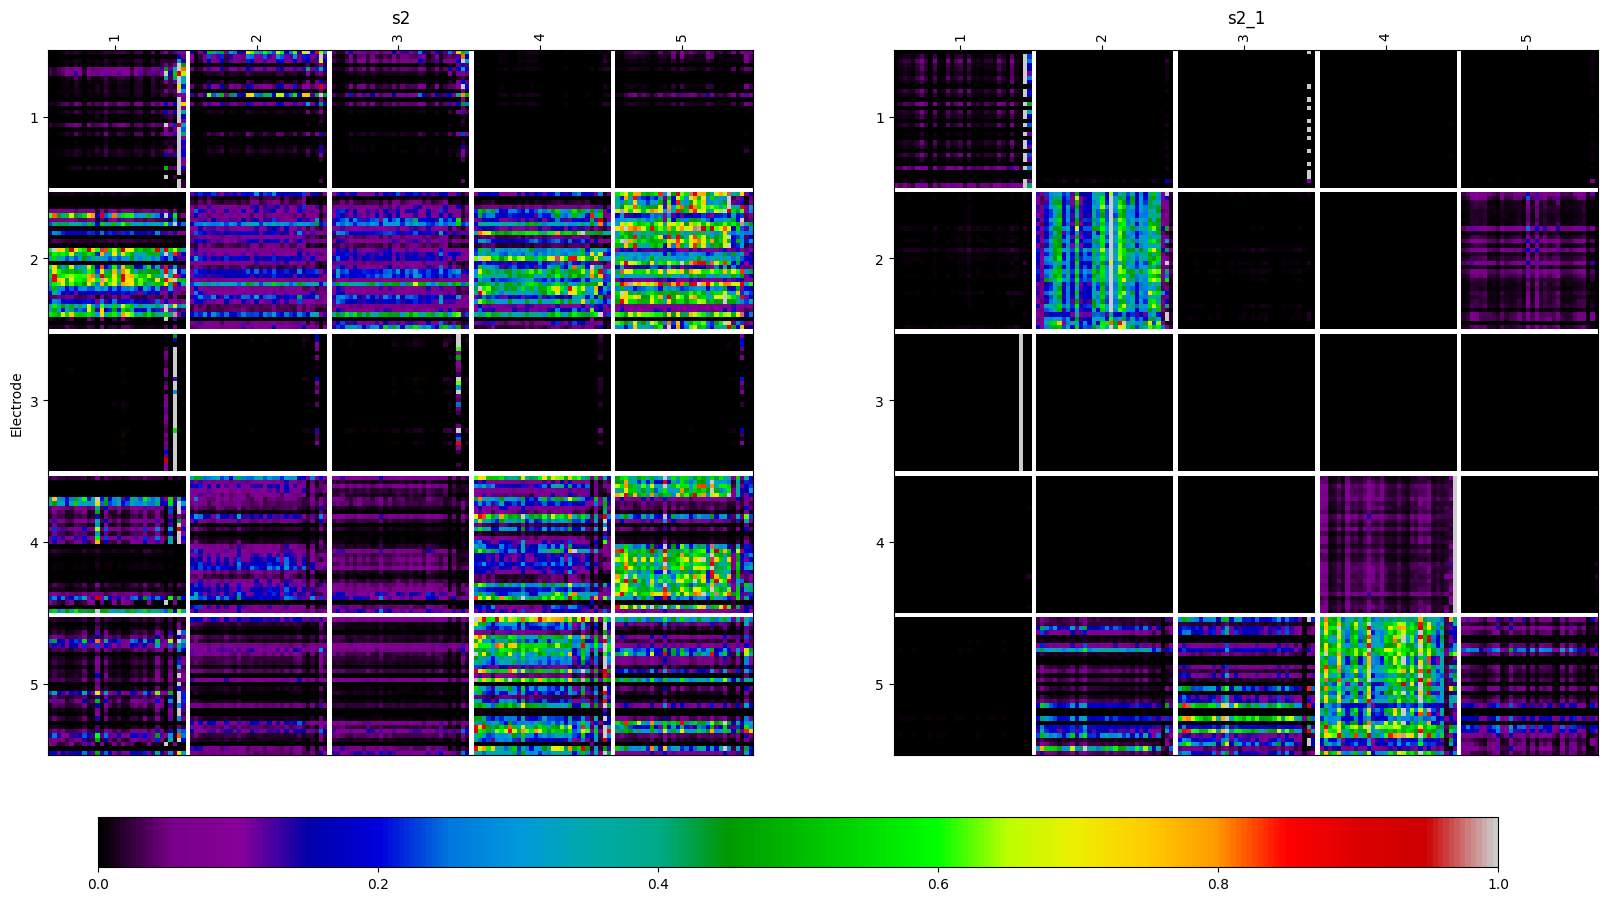

In [17]:
s2 = "/home/dan/Documents/images/singleTokenPreds/paper_nets/run-20240131_113012-94308ezc/files/self_attn_930_layer_0_head_0.npy"
attention1 = np.load(s2)

s2_1 = "/home/dan/Documents/images/singleTokenPreds/run-20240202_092602-qx6m88kp/files/self_attn_4650_layer_0_head_0.npy"
attention2 = np.load(s2_1)

titles = ["s2",
          "s2_1"]
names = ["1,2,3,4,5".split(','), 
         "1,2,3,4,5".split(',')]
combined_plot([attention1, attention2], names, titles, 32, same_order=True, maxval=1);